# Final Assignment for Coursera Specialization: IBM Data Science Professional Certificate

## Project: MACPEC - Menu Augmentation Campaign with Popular Ethnic Cuisine

### Introduction
#### Outset
Let us assume that we have been contacted by a major restaurant chain operating in Canada and the US. As an effort to attract more customers the enterprise would like to augment their menus with a range of dishes of locally popular foreign cuisine. While they are predisposed to include different menus in different towns, for logistic and administrative reasons they would like to keep the number of different cuisines to a minimum, i.e. 5. 
#### Problem
Our task is to find out which cuisines are most popular in the major (more than 100’000 inhabitants) US and Canadian cities/towns and provide them in maximally 5 groups with cuisine recommendations. 
#### Interest
Knowing the local taste of customers and adapt local menus can have a major impact on large restaurant chains and their business value, because serving popular food will attract more customers. Furthermore local customers may appreciate to find all their most favourite food in a single establishment. 
#### Approach
Our initial assumption is that we can approximate the popularity of a cuisine with its presence in a town relative to other present cuisines. In other words, a cuisine that has many restaurants in a town is likely to be a popular cuisine in that town. With this assumption, we generate a cuisine data set for US/CAN cities/towns and cluster the data into 5 groups, which forms the basis of our final recommendation.

### Python Libraries for Data Retrieval and Analysis

Installing and importing all required libraries. This may take some time. 
Libraries:

1. numpy - improved numerical representations
1. pandas - data frames
1. time - (here) used to allow pausing code execution, which helps to avoid request denials due to high traffic web requests
1. re - regular expression; contains useful methods for datatype STR
1. itertools - simplifying loops
1. urllib - handles HTML requests
1. requests - handles JSON requests
1. bs4 - scrapes STR data of various forms, including HTML source code
1. geopy - gets coordinates for locations
1. matplotlib - plotting routines
1. folium - improved map plots
1. wordcloud - creates word clouds
1. sklearn - machine learning methods, here: KMeans

In [6]:
# install software libraries, please uncomment the lines with libraries that are not yet installed in your environment
# install Geopy
# !conda install -c conda-forge geopy --yes 
# install wordcloud
# !conda install -c conda-forge wordcloud==1.4.1 --yes
# install Folium
# !conda install -c conda-forge folium=0.5.0 --yes

In [7]:
# import python libraries
import numpy as np
import pandas as pd
import time
import re
import itertools
from urllib import request
import requests # library to handle requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude valuesimport matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans

%matplotlib inline

Foursquare user information. Note that the information here is only an example and not actually working. Insert your ID, SECRET and VERSION.

In [8]:
# @hidden_cell
CLIENT_ID = 'MUQZABRY5SR2BN5BHN34QIZZFEINQ14UUNEBECF0N10HS4YAB' # your Foursquare ID, this is only an example that doesn't work
CLIENT_SECRET = 'NVSUKVIBHZCXLIT51R3U434X5OCDK1KTKXV5H1ERZ3COBY0NB' # your Foursquare Secret, this is only an example that doesn't work
VERSION = '20180605' # Foursquare API version, this is only an example that doesn't work

### Data
We need a data base of US and Canadian cities and towns with more than 100’000 inhabitants. We can find lists ordered by population on Wikipedia, which we can scrape for city names, regions and coordinates for cities with more than 100’000 inhabitants. This results in a database of the largest US and Canadian cities. 

Let's request the html files for the Wikipedia sites with US and Canadian cities ordered by population. We then scrape the html code with BeautifulSoup to extract the html code of the corresponding tables. 

In [9]:
US_Cities_list_wiki="https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
CA_Cities_list_wiki="https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population"

US_Cities_soup=BeautifulSoup(request.urlopen(US_Cities_list_wiki), 'html.parser')
CA_Cities_soup=BeautifulSoup(request.urlopen(CA_Cities_list_wiki), 'html.parser')

print('The title tag of the imported US City list HTML is:\n\n' + US_Cities_soup.title.prettify() + '\n')
print('The title tag of the imported Canada City list HTML is:\n\n' + CA_Cities_soup.title.prettify() + '\n')

The title tag of the imported US City list HTML is:

<title>
 List of United States cities by population - Wikipedia
</title>


The title tag of the imported Canada City list HTML is:

<title>
 List of the 100 largest municipalities in Canada by population - Wikipedia
</title>




Creating tables from html strings:

In [10]:
# US Cities:
list_USC = pd.read_html(str(US_Cities_soup.find('table',{'class':"wikitable sortable"})))
df_USC   = pd.DataFrame(list_USC[0])
print("US Cities over 100k inhabitants:")
print(df_USC.head())
# Canadian Cities:
list_CAC = pd.read_html(str(CA_Cities_soup.find('table',{'class':"wikitable sortable"})))
df_CAC   = pd.DataFrame(list_CAC[0])
print("\nCanadian Cities over 100k inhabitants:")
print(df_CAC.head())

US Cities over 100k inhabitants:
   2019rank         City    State[c]  2019estimate  2010Census   Change  \
0         1  New York[d]    New York       8336817     8175133   +1.98%   
1         2  Los Angeles  California       3979576     3792621   +4.93%   
2         3      Chicago    Illinois       2693976     2695598   −0.06%   
3         4   Houston[3]       Texas       2320268     2100263  +10.48%   
4         5      Phoenix     Arizona       1680992     1445632  +16.28%   

  2016 land area 2016 land area.1 2016 population density  \
0    301.5 sq mi        780.9 km2            28,317/sq mi   
1    468.7 sq mi      1,213.9 km2             8,484/sq mi   
2    227.3 sq mi        588.7 km2            11,900/sq mi   
3    637.5 sq mi      1,651.1 km2             3,613/sq mi   
4    517.6 sq mi      1,340.6 km2             3,120/sq mi   

  2016 population density.1                                         Location  
0                10,933/km2    40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.

Cleaning and combining tables to form a single dataframe with all Canadian and US cities:

In [11]:
# Cleaning tables to include only city name and population (sort value), only include cities with more than 100000 registered inhabitants. 
df_USC=df_USC[['City','State[c]','2019estimate']]
df_USC.rename(columns={'State[c]':'Province/State','2019estimate':'Population'},inplace=True)
df_CAC=df_CAC[df_CAC['Population(2016)']>100000]
df_CAC=df_CAC[['Municipality','Province','Population(2016)']]
df_CAC.rename(columns={'Municipality':'City','Province':'Province/State','Population(2016)':'Population'},inplace=True)
# Some city names need cleaning from footnote markers in source.
df_USC['City'] = [re.sub("\[\w+\]","",city) for city in list(df_USC['City'])]
df_USC['Province/State'] = [re.sub("\[\w+\]","",state) for state in list(df_USC['Province/State'])]
df_CAC['City'] = [re.sub("\[\w+\]","",city) for city in list(df_CAC['City'])]
df_CAC['Province/State'] = [re.sub("\[\w+\]","",state) for state in list(df_CAC['Province/State'])]
# Combining US and Canadian cities in one dataframe
df_cities=pd.concat([df_USC,df_CAC]).sort_values('Population',ascending=False).reset_index(drop=True)
print("\nTail(20) of dataframe of all Cities:")
df_cities.tail(20)


Tail(20) of dataframe of all Cities:


,City,Province/State,Population
351,Las Cruces,New Mexico,103432
352,Chico,California,103301
353,El Cajon,California,102708
354,Burbank,California,102511
355,Delta,British Columbia,102238
356,South Bend,Indiana,102026
357,Renton,Washington,101751
358,Chatham-Kent,Ontario,101647
359,Vista,California,101638
360,Davenport,Iowa,101590


Let's get all coordinates for the cities. Here we request the location data from Geopy and add it to the dataframe. Note, that it appears that calls to Geopy are limited in number during a specific time, therefore we may need to iterate several times through the Geopy call as there can be denied requests.


In [12]:
cities_file="cities.pkl"
try:
    df_cities = pd.read_pickle(cities_file)
except:
    # initialise the new columns
    if 'Latitude' not in df_cities.columns:
        df_cities['Latitude']=np.nan
    if 'Longitude' not in df_cities.columns:
        df_cities['Longitude']=np.nan
    # initialise geopy parameter
    geolocator = Nominatim(user_agent="geo_explorer")
    # repeat until the last city has coordinates
    while np.isnan(df_cities.loc[df_cities.index[-1],'Latitude']):
        # iterate through all cities starting from the first
        for city,reg in zip(list(df_cities['City']),list(df_cities['Province/State'])):
            try:
                if np.isnan(df_cities[(df_cities['City']==city)&(df_cities['Province/State']==reg)]['Latitude'].values):
                    # if the city does not yet have coordinates, request them from Geopy for city + province/state
                    location = geolocator.geocode(city+", "+reg)
                    latitude = location.latitude
                    longitude = location.longitude
                    df_cities.loc[(df_cities['City']==city)&(df_cities['Province/State']==reg),'Latitude']=latitude
                    df_cities.loc[(df_cities['City']==city)&(df_cities['Province/State']==reg),'Longitude']=longitude
                    print(location)
            except:
                # sometimes geopy denies the request (perhaps due to many requests in a given, short time). 
                # Should that be the case, we wait a moment before trying again.
                print("Request denied! Let's try again after one second.")
                time.sleep(1)
                break
    df_cities.reset_index(inplace=True)
    df_cities.to_pickle(cities_file)
df_cities.tail()

New York, United States of America
Los Angeles, Los Angeles County, California, United States of America
Toronto, Golden Horseshoe, Ontario, M5H 2N2, Canada
Chicago, Cook County, Illinois, United States of America
Houston, Harris County, Texas, United States of America
Montréal, Agglomération de Montréal, Montréal (06), Québec, Canada
Phoenix, Maricopa County, Arizona, United States of America
Philadelphia, Philadelphia County, Pennsylvania, United States of America
San Antonio, Bexar County, Texas, United States of America
San Diego, San Diego County, California, United States of America
Dallas, Dallas County, Texas, United States of America
Calgary, Alberta, Canada
San Jose, Santa Clara County, California, United States of America
Austin, Travis County, Texas, United States of America
Ottawa, Eastern Ontario, Ontario, K1P 1J1, Canada
Edmonton, Alberta, Canada
Jacksonville, Duval County, Florida, United States of America
Fort Worth, Tarrant County, Texas, United States of America
Colu

Grand Rapids, Kent County, Michigan, United States of America
Huntsville, Madison County, Alabama, United States of America
Salt Lake City, Salt Lake County, Utah, United States of America
Frisco, Collin County, Texas, United States of America
Yonkers, Westchester County, New York, United States of America
Amarillo, Potter County, Texas, 79105, United States of America
Glendale, Los Angeles County, California, United States of America
Huntington Beach, Orange County, California, 92648, United States of America
McKinney, Collin County, Texas, United States of America
Montgomery, Montgomery County, Alabama, United States of America
Richmond, Metro Vancouver Regional District, British Columbia, Canada
Augusta, Richmond County, Georgia, United States of America
Aurora, Kane County, Illinois, United States of America
Akron, Summit County, Ohio, United States of America
Little Rock, Arkansas, United States of America
Tempe, Maricopa County, Arizona, United States of America
Columbus, Muscoge

Columbia, Boone County, Missouri, United States of America
Pearland, Brazoria County, Texas, United States of America
Victorville, San Bernardino County, California, United States of America
Hartford, Hartford County, Connecticut, United States of America
Vallejo, Solano County, California, United States of America
Allentown, Lehigh County, Pennsylvania, United States of America
Berkeley, Alameda County, California, United States of America
Richardson, Dallas County, Texas, United States of America
Arvada, Jefferson County, Colorado, United States of America
Ann Arbor, Washtenaw County, Michigan, United States of America
Ajax, Durham Region, Golden Horseshoe, Ontario, Canada
Rochester, Olmsted County, Minnesota, United States of America
Cambridge, Middlesex County, Massachusetts, United States of America
Sugar Land, Fort Bend County, Texas, United States of America
Lansing, Ingham County, Michigan, United States of America
Evansville, Vanderburgh County, Indiana, 47713, United States o

,index,City,Province/State,Population,Latitude,Longitude
366,366,Vacaville,California,100670,38.356577,-121.987744
367,367,Clinton,Michigan,100471,42.943524,-84.612534
368,368,Bend,Oregon,100421,44.058173,-121.315310
369,369,Red Deer,Alberta,100418,52.269838,-113.818359
370,370,Woodbridge,New Jersey,100145,40.554180,-74.286001


Now that we have location data we can search the Foursquare data base for all restaurants that are in these cities at around 5km of the city center. We limit the results to 1000 per city. First, we define a funcion that organises the Foursquare queries and provides us conveniently with a dataframe of restaurants at each of the queried cities.

In [13]:
# function that returns nearby restaurants for 5000m around the center of a city
def getNearbyRestaurants(idxs, names, regs, latitudes, longitudes, radius=5000, LIMIT=100):
    
    restaurants_list=[]
    for idx, name, reg, lat, lng in zip(idxs, names, regs, latitudes, longitudes):
        print(name + ", " + reg)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            'Lunch',
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            results=[]
        
        # return only relevant information for each nearby venue
        restaurants_list.append([(
            idx,
            name, 
            reg,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_restaurants = pd.DataFrame([item for restaurant_list in restaurants_list for item in restaurant_list])
    try:
        nearby_restaurants.columns = ['index', 
                  'City',
                  'Province/State',
                  'City Latitude', 
                  'City Longitude', 
                  'Restaurant', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category']
    except:
        pass
    
    return(nearby_restaurants)

Then, we call the function to obtain the restaurant dataframe:

In [14]:
restaurants_file="restaurants.pkl"
try:
    df_restaurants = pd.read_pickle(restaurants_file)
except:
    df_restaurants = getNearbyRestaurants(
                                    idxs=df_cities['index'],
                                    names=df_cities['City'],
                                    regs=df_cities['Province/State'],
                                    latitudes=df_cities['Latitude'],
                                    longitudes=df_cities['Longitude']
                                  )
    df_restaurants.to_pickle(restaurants_file)
    
df_restaurants.tail(20)

New York, New York
Los Angeles, California
Toronto, Ontario
Chicago, Illinois
Houston, Texas
Montreal, Quebec
Phoenix, Arizona
Philadelphia, Pennsylvania
San Antonio, Texas
San Diego, California
Dallas, Texas
Calgary, Alberta
San Jose, California
Austin, Texas
Ottawa, Ontario
Edmonton, Alberta
Jacksonville, Florida
Fort Worth, Texas
Columbus, Ohio
Charlotte, North Carolina
San Francisco, California
Indianapolis, Indiana
Seattle, Washington
Denver, Colorado
Mississauga, Ontario
Washington, District of Columbia
Winnipeg, Manitoba
Boston, Massachusetts
El Paso, Texas
Nashville, Tennessee
Detroit, Michigan
Oklahoma City, Oklahoma
Portland, Oregon
Las Vegas, Nevada
Memphis, Tennessee
Vancouver, British Columbia
Louisville, Kentucky
Brampton, Ontario
Baltimore, Maryland
Milwaukee, Wisconsin
Albuquerque, New Mexico
Tucson, Arizona
Hamilton, Ontario
Quebec City, Quebec
Fresno, California
Mesa, Arizona
Surrey, British Columbia
Sacramento, California
Atlanta, Georgia
Kansas City, Missouri
Colora

,index,City,Province/State,City Latitude,City Longitude,Restaurant,Restaurant Latitude,Restaurant Longitude,Restaurant Category
32866,370,Woodbridge,New Jersey,40.55418,-74.286001,Ling's Chinese Kitchen,40.527871,-74.311941,Chinese Restaurant
32867,370,Woodbridge,New Jersey,40.55418,-74.286001,Philly Pretzel Factory,40.533934,-74.334284,Restaurant
32868,370,Woodbridge,New Jersey,40.55418,-74.286001,MIRCHI SOUTH INDIAN HOMESTYLE,40.572420,-74.339937,Indian Restaurant
32869,370,Woodbridge,New Jersey,40.55418,-74.286001,Garibaldi Mexican Restaurant,40.510457,-74.275454,Mexican Restaurant
32870,370,Woodbridge,New Jersey,40.55418,-74.286001,Mithaas,40.571129,-74.339450,Indian Restaurant
32871,370,Woodbridge,New Jersey,40.55418,-74.286001,White Castle,40.546761,-74.328751,Fast Food Restaurant
32872,370,Woodbridge,New Jersey,40.55418,-74.286001,El Tex Mex Burrito & Cafe,40.527937,-74.312611,Mexican Restaurant
32873,370,Woodbridge,New Jersey,40.55418,-74.286001,Shalimar Kandahar Afghani & Turkish Restaurant,40.573831,-74.325912,Afghan Restaurant
32874,370,Woodbridge,New Jersey,40.55418,-74.286001,Sigiri,40.557238,-74.343664,Sri Lankan Restaurant
32875,370,Woodbridge,New Jersey,40.55418,-74.286001,Singa's Famous Pizza,40.571092,-74.339387,Pizza Place


The restaurant category data retrieved from Foursquare is very heterogenous and difficult to work with as it is. Our principal interest are not exactly the categories but the cuisines of each restaurant and several categories can relate to the same cuisine. Fortunately, the Foursquare categories represent largely the restaurant cuisines though, so that only a minimum effort was required to clean the data set. As an example, a typical Foursquare venue category is “Italian Restaurant”, which includes the “Italian” cuisine as descriptive adjective with the overall category “Restaurant”. Most categories follow this example and only require iterative text scraping to transform into cuisines automatically.  Some categories needed manual assignment, however. After identifying categories which do not directly specify the cuisine, e.g. “Pizza Place”, “Taco Place” or “Udon Restaurant”, we defined a dictionary to translate these categories into their respective cuisines, that is “Italian”, “Mexican” and “Japanese”, respectively. Any category that is not clearly identifiable as an ethnic cuisine, such as “American Restaurant”, “Sandwich Place” or “Salad Bar” are not relevant to our current analysis and thus, were dropped. 

First we only keep restaurants which are in the category of either "Restaurant" or "Place".

In [23]:
patterns=re.compile(r'( Restaurant)|( Place)') 
df_restaurants_sub=df_restaurants[['index','Restaurant Category']].loc[[patterns.search(rest) is not None for rest in df_restaurants['Restaurant Category']]]
df_restaurants_sub['Restaurant Category']=[rest[0:(patterns.search(rest).span()[0])] for rest in df_restaurants_sub['Restaurant Category']]
df_restaurants_sub.reset_index(inplace=True,drop=True)
#df_restaurants_sub['Restaurant Category'].value_counts()

Dictionary for manual assignment:

In [24]:
replace_dict={'Pizza':'Italian','Indian Chinese':'Indian','Japanese Curry':'Japanese','Paella':'Spanish','Empanada':'Argentinian',
              'North Indian':'Indian','Udon':'Japanese','Cajun / Creole':'Japanese','Burrito':'Mexican','Tibetan':'Indian',
              'Venezuelan':'Latin American','Jewish':'Israeli','Ramen':'Japanese','Taco':'Mexican','Sushi':'Japanese','Bavarian':'German',
              'Persian':'Middle Eastern','Tex-Mex':'Mexican','Himalayan':'Indian','Tapas':'Spanish','Caucasian':'East European',
              'Polish':'East European','Romanian':'East European','Russian':'East European','Hong Kong':'Chinese','Falafel':'Israeli',
              'Hungarian':'East European','South Indian':'Indian','Shanghai':'Chinese','Cantonese':'Chinese','Iraqi':'Middle Eastern',
              'Arepa':'Argentinian','Moroccan':'African','Chaat':'Indian','Soba':'Japanese','Indonesian':'South East Asian',
              'Satay':'South East Asian','Shabu-Shabu':'Japanese','Donburi':'Japanese','Hunan':'Chinese','Salvadoran':'Caribbean',
              'Hotpot':'Chinese','Burmese':'South East Asian','Sri Lankan':'South East Asian','Doner':'Turkish','Kebab':'Turkish',
              'Dim Sum':'Chinese','Malay':'South East Asian','Szechuan':'Chinese','Belgian':'Modern European','English':'Modern European',
              'Fondue':'Modern European','Lebanese':'African','Ethiopian':'African','Colombian':'South American',
              'Cambodian':'South East Asian','Poke':'Hawaiian'}
{k: v for k, v in sorted(replace_dict.items(), key=lambda item: item[1])}

{'Moroccan': 'African',
 'Lebanese': 'African',
 'Ethiopian': 'African',
 'Empanada': 'Argentinian',
 'Arepa': 'Argentinian',
 'Salvadoran': 'Caribbean',
 'Hong Kong': 'Chinese',
 'Shanghai': 'Chinese',
 'Cantonese': 'Chinese',
 'Hunan': 'Chinese',
 'Hotpot': 'Chinese',
 'Dim Sum': 'Chinese',
 'Szechuan': 'Chinese',
 'Caucasian': 'East European',
 'Polish': 'East European',
 'Romanian': 'East European',
 'Russian': 'East European',
 'Hungarian': 'East European',
 'Bavarian': 'German',
 'Poke': 'Hawaiian',
 'Indian Chinese': 'Indian',
 'North Indian': 'Indian',
 'Tibetan': 'Indian',
 'Himalayan': 'Indian',
 'South Indian': 'Indian',
 'Chaat': 'Indian',
 'Jewish': 'Israeli',
 'Falafel': 'Israeli',
 'Pizza': 'Italian',
 'Japanese Curry': 'Japanese',
 'Udon': 'Japanese',
 'Cajun / Creole': 'Japanese',
 'Ramen': 'Japanese',
 'Sushi': 'Japanese',
 'Soba': 'Japanese',
 'Shabu-Shabu': 'Japanese',
 'Donburi': 'Japanese',
 'Venezuelan': 'Latin American',
 'Burrito': 'Mexican',
 'Taco': 'Mexican'

Manual assigment of cuisine categories with dictionary and value count of cuisines in dataframe:

In [25]:
replace_pattern = re.compile(r'\b(' + '|'.join(replace_dict.keys()) + r')\b')
df_restaurants_sub['Restaurant Category'] = [replace_pattern.sub(lambda x: replace_dict[x.group()], string) for string in df_restaurants_sub['Restaurant Category']]
df_restaurants_sub['Restaurant Category'].value_counts()

Italian                 3888
Mexican                 3382
Sandwich                2276
American                1944
Fast Food               1861
Japanese                1508
Chinese                 1024
Seafood                  746
Thai                     618
Asian                    529
Vietnamese               502
New American             378
Indian                   348
Mediterranean            341
Vegetarian / Vegan       255
Greek                    244
French                   211
Middle Eastern           204
Southern / Soul Food     204
Latin American           174
Korean                   170
Spanish                  124
Caribbean                113
Salad                    113
Cuban                     81
Hawaiian                  76
Snack                     75
German                    74
Peruvian                  60
Israeli                   59
Brazilian                 56
African                   52
South American            43
Argentinian               41
Portuguese    

Any category that is not clearly identifiable as an ethnic cuisine, such as “American”, “Sandwich” or “Soup” are not relevant to our current analysis and thus, were dropped. We select a set of 38 cuisines that can clearly be identified as ethnic cuisines and drop the rest. There remain a number of 14173 restaurants in the data set:

In [26]:
Cuisines={'Italian','Mexican','Japanese','Chinese','Thai','Asian','Vietnamese','Indian',
          'Modern European','Mediterranean','Greek','French','Middle Eastern','Latin American','Korean','Spanish','Caribbean','Cuban',
          'German','Peruvian','Brazilian','Israeli','African','Hawaiian','South American','Portuguese','Argentinian','South East Asian',
          'Filipino','Eastern European','Turkish','Mongolian','Afghan','East European','Scandinavian','Pakistani','Taiwanese','Australian'}
df_restaurants_sub['Restaurant Category'] = df_restaurants_sub['Restaurant Category'].loc[[cuisine in Cuisines for cuisine in list(df_restaurants_sub['Restaurant Category'])]]
df_restaurants_sub.dropna(axis=0,inplace=True)
df_restaurants_sub.rename(columns={'Restaurant Category':'Cuisine'},inplace=True)
df_restaurants_sub.reset_index(inplace=True,drop=True)
print(df_restaurants_sub.shape)
df_restaurants_sub['Cuisine'].value_counts()

(14173, 2)


Italian             3888
Mexican             3382
Japanese            1508
Chinese             1024
Thai                 618
Asian                529
Vietnamese           502
Indian               348
Mediterranean        341
Greek                244
French               211
Middle Eastern       204
Latin American       174
Korean               170
Spanish              124
Caribbean            113
Cuban                 81
Hawaiian              76
German                74
Peruvian              60
Israeli               59
Brazilian             56
African               52
South American        43
Portuguese            41
Argentinian           41
Modern European       37
South East Asian      28
Filipino              28
Eastern European      26
Turkish               21
Mongolian             16
Afghan                13
Scandinavian          10
East European         10
Pakistani              9
Taiwanese              8
Australian             4
Name: Cuisine, dtype: int64

Let us define a function to extract cuisines from the dataframe as a continous string, so that we can analyse the text data as a word cloud and more easily identify dominant cuisines graphically.

In [27]:
def return_str(df,cluster_idx=0):
    if 'Cluster Labels' in df.columns:
        temp=df.drop(columns=['City'])
        temp=temp.loc[temp['Cluster Labels'] == cluster_idx, temp.columns[[1] + list(range(5, temp.shape[1]))]].values.tolist()
        temp=list(itertools.chain(*temp))
    else:
        temp=list(df['Cuisine'])
    
    temp=" ".join(temp)
    return(temp)


Let's check out the word cloud for the entire data set of cuisines.

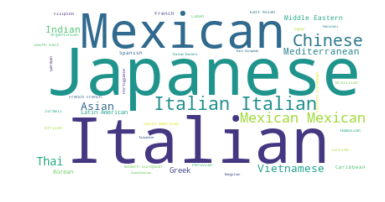

In [29]:
restaurant_cloud = WordCloud(
    background_color='white',
    max_words=20000,
    stopwords=STOPWORDS
)

# generate string of all cuisines from dataframe
restaurant_str=return_str(df_restaurants_sub)
# generate the word cloud
restaurant_cloud.generate(restaurant_str)

# display the word cloud
plt.imshow(restaurant_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()



We need to normalise the cuisine data for each city. For this we one-hot-encode the cuisine data for each restaurant and then group this data for each city by taking the average of each cuisine. We will use the index of the towns in our city dataframe as unique key that uniquely defines the corresponding city.

In [30]:
# one hot encoding
restaurants_onehot = pd.get_dummies(df_restaurants_sub[['Cuisine']], prefix="", prefix_sep="")
restaurants_onehot['index'] = df_restaurants_sub['index']
restaurants_grouped = restaurants_onehot.groupby('index').mean().reset_index()
restaurants_grouped.tail()

,index,Afghan,African,Argentinian,Asian,Australian,Brazilian,Caribbean,Chinese,Cuban,...,Peruvian,Portuguese,Scandinavian,South American,South East Asian,Spanish,Taiwanese,Thai,Turkish,Vietnamese
347,365,0.000000,0.0,0.0,0.026316,0.0,0.0,0.000000,0.052632,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.026316
348,366,0.000000,0.0,0.0,0.068182,0.0,0.0,0.000000,0.113636,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.068182,0.000000,0.045455
349,368,0.000000,0.0,0.0,0.046512,0.0,0.0,0.000000,0.046512,0.0,...,0.046512,0.0,0.0,0.0,0.000000,0.023256,0.0,0.069767,0.000000,0.069767
350,369,0.000000,0.0,0.0,0.086957,0.0,0.0,0.000000,0.130435,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.086957,0.000000,0.086957
351,370,0.017857,0.0,0.0,0.035714,0.0,0.0,0.035714,0.089286,0.0,...,0.017857,0.0,0.0,0.0,0.017857,0.017857,0.0,0.000000,0.017857,0.000000


We sort cuisines for each city for popularity, which we assume equal to its occurrence. For each city we compute the 7 most popular cuisines and continue to work with that data for recommending which cuisines are most popular in sets of cities.

In [31]:
def return_most_common(row, num_top):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top]

num_top = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['index']
for ind in np.arange(num_top):
    try:
        columns.append('{}{} Most Common Cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Cuisine'.format(ind+1))

# create a new dataframe
restaurants_sorted = pd.DataFrame(columns=columns)
restaurants_sorted['index'] = restaurants_grouped['index']

for ind in np.arange(restaurants_grouped.shape[0]):
    restaurants_sorted.iloc[ind, 1:] = return_most_common(restaurants_grouped.iloc[ind, :], num_top)

restaurants_sorted.head()

,index,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine
0,0,Italian,Israeli,Japanese,French,Mexican,Caribbean,Chinese
1,1,Japanese,Mexican,Italian,Chinese,French,Asian,Filipino
2,2,Italian,Japanese,Mexican,Thai,French,Hawaiian,Middle Eastern
3,3,Italian,Japanese,Mexican,Mediterranean,Middle Eastern,Peruvian,French
4,4,Mexican,Italian,Vietnamese,Japanese,French,Greek,Mediterranean


Before we can recommend cuisines for city sets, we need to analyse which cities are similar, for this we employ K-Means with k=5. 

In [32]:
# set number of clusters
kclusters = 5

restaurants_grouped_clustering = restaurants_grouped.drop('index', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=52).fit(restaurants_grouped_clustering)

#restaurants_sorted.drop('Cluster Labels',axis=1,inplace=True)
# add clustering labels
restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_) # can be reset with: "restaurants_sorted.drop('Cluster Labels',axis=1,inplace=True)"

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 2, 3, 1, 0, 1, 0, 4], dtype=int32)

Having identified clusters of similar cities, we can merge all present information (city info, popular cuisines and cluster correspondence).

In [33]:
restaurants_merged = df_cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
restaurants_merged = restaurants_merged.join(restaurants_sorted.set_index('index'), on='index')

# keep cluster index as Integer
restaurants_merged['Cluster Labels']=restaurants_merged['Cluster Labels'].astype('Int64')
# drop NaNs
restaurants_merged.dropna(inplace=True)
# reset index after removing NaN
restaurants_merged.reset_index(inplace=True,drop=True) 
restaurants_merged.drop('index',axis=1,inplace=True)
restaurants_merged.tail() 
 
 
 

,City,Province/State,Population,Latitude,Longitude,Cluster Labels,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine
347,San Angelo,Texas,101004,31.464836,-100.439844,0,Mexican,Italian,Japanese,Chinese,Asian,Vietnamese,South American
348,Vacaville,California,100670,38.356577,-121.987744,3,Mexican,Italian,Chinese,Japanese,Thai,Asian,Vietnamese
349,Bend,Oregon,100421,44.058173,-121.315310,3,Mexican,Italian,Japanese,Vietnamese,Thai,Asian,Chinese
350,Red Deer,Alberta,100418,52.269838,-113.818359,3,Mexican,Italian,Chinese,Japanese,Asian,Vietnamese,Thai
351,Woodbridge,New Jersey,100145,40.554180,-74.286001,2,Italian,Indian,Mexican,Chinese,Japanese,Asian,Caribbean


We need the following code to enable a legend on the folium map:

In [209]:
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 1</li>
    <li><span style='background:purple;opacity:0.7;'></span>Cluster 2</li>
    <li><span style='background:green;opacity:0.7;'></span>Cluster 3</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 4</li>
    <li><span style='background:orange;opacity:0.7;'></span>Cluster 5</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)


Let us plot the cluster distribution on a map:

In [210]:
address='USA'
geolocator = Nominatim(user_agent="geo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(restaurants_merged['Latitude'], restaurants_merged['Longitude'], restaurants_merged['City'], restaurants_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters.get_root().add_child(macro)

map_clusters.save('cluster_map.html')
map_clusters

The geograpical coordinate of USA are 39.7837304, -100.4458825.


Now, we can recommend cuisines for each of the clusters:

#### Cluster 1 - Mexican and International (Southern USA)

58


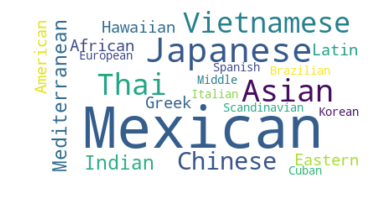

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine
6,Phoenix,Mexican,Italian,Middle Eastern,Chinese,Mediterranean,Vietnamese,Peruvian
8,San Antonio,Mexican,Italian,Japanese,Modern European,Asian,Brazilian,Chinese
13,Austin,Mexican,Italian,Japanese,Chinese,Indian,Korean,Latin American
17,Fort Worth,Mexican,Italian,Japanese,Mediterranean,Thai,Chinese,Middle Eastern
21,Indianapolis,Mexican,Italian,Japanese,Modern European,Greek,German,Middle Eastern
28,El Paso,Mexican,Italian,Japanese,Thai,Chinese,Israeli,Spanish
33,Las Vegas,Mexican,Italian,Thai,Japanese,Hawaiian,Latin American,Modern European
40,Albuquerque,Mexican,Italian,Japanese,Middle Eastern,Asian,Caribbean,Modern European
41,Tucson,Mexican,Italian,Chinese,French,Indian,Middle Eastern,African
44,Fresno,Mexican,Italian,Asian,Chinese,Vietnamese,Japanese,Mediterranean


In [211]:
cluster=1
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

#### Cluster 2 - Mexican and Asian (USA, western skewed)

119


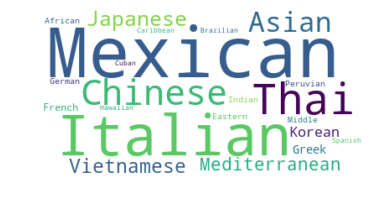

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine
4,Houston,Mexican,Italian,Vietnamese,Japanese,French,Greek,Mediterranean
10,Dallas,Mexican,Italian,Japanese,Thai,African,Asian,Brazilian
12,San Jose,Mexican,Japanese,Italian,Vietnamese,Greek,African,Asian
14,Ottawa,Italian,Mexican,Spanish,Japanese,Middle Eastern,Asian,Chinese
16,Jacksonville,Mexican,Italian,Japanese,Thai,Asian,Caribbean,Mediterranean
18,Columbus,Mexican,Italian,German,Japanese,Asian,Greek,Latin American
39,Milwaukee,Mexican,Italian,Thai,Greek,Japanese,African,Chinese
45,Mesa,Mexican,Italian,Asian,Chinese,Korean,Thai,South American
47,Sacramento,Italian,Mexican,Japanese,Chinese,Thai,Spanish,African
48,Atlanta,Mexican,Italian,Caribbean,Japanese,Mediterranean,Vietnamese,Hawaiian


In [205]:
cluster=2
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

#### Cluster 3 - Asian and Mediterranean (USA, eastern skewed)

29


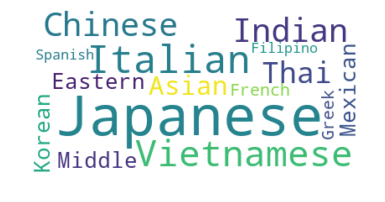

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine
1,Los Angeles,Japanese,Mexican,Italian,Chinese,French,Asian,Filipino
24,Mississauga,Indian,Italian,Japanese,Asian,Vietnamese,Mexican,Chinese
26,Winnipeg,Italian,Japanese,Asian,French,Vietnamese,Indian,Chinese
35,Vancouver,Japanese,Mexican,Italian,Chinese,Middle Eastern,African,Vietnamese
46,Surrey,Japanese,Indian,Italian,Chinese,Greek,Mexican,Korean
56,Oakland,Mexican,Vietnamese,Chinese,Japanese,Italian,South East Asian,African
59,Halifax,Italian,Japanese,Chinese,Mexican,Middle Eastern,Turkish,Vietnamese
62,New Orleans,Japanese,Italian,Mexican,French,Vietnamese,German,South American
66,Cleveland,Italian,Japanese,Mexican,Vietnamese,Thai,French,Mediterranean
69,Honolulu,Japanese,Chinese,Italian,Hawaiian,Mexican,Korean,Mediterranean


In [206]:
cluster=3
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

#### Cluster 4 - predominantly Asian (Canada and Eastern USA + Alaska + Hawaii)

88


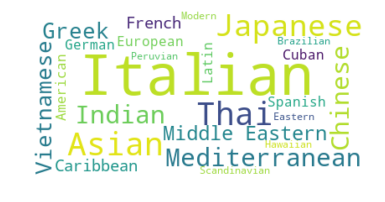

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine
3,Chicago,Italian,Japanese,Mexican,Mediterranean,Middle Eastern,Peruvian,French
9,San Diego,Italian,Mexican,Japanese,Middle Eastern,Brazilian,Thai,Israeli
19,Charlotte,Italian,Mexican,Japanese,Thai,Mediterranean,Peruvian,French
23,Denver,Italian,Mexican,Asian,Japanese,Mediterranean,Middle Eastern,French
27,Boston,Italian,Mexican,Greek,French,Asian,Japanese,Chinese
29,Nashville,Italian,Mexican,Greek,Modern European,Caribbean,Chinese,Indian
36,Louisville,Italian,Mexican,Japanese,Mediterranean,Asian,Chinese,African
51,Omaha,Italian,Mexican,Japanese,Chinese,French,African,Asian
55,Virginia Beach,Italian,Mexican,Mediterranean,Thai,Japanese,Modern European,Latin American
58,Laval,Italian,Japanese,French,Mexican,Asian,Chinese,Brazilian


In [214]:
cluster=4
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

#### Cluster 5 - predominantly Mediterranean/European (Eastern USA and Canada)

63


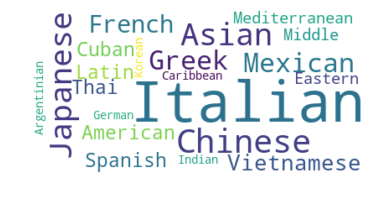

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine
0,New York,Italian,Israeli,Japanese,French,Mexican,Caribbean,Chinese
2,Toronto,Italian,Japanese,Mexican,Thai,French,Hawaiian,Middle Eastern
5,Montreal,Italian,Portuguese,French,Japanese,Mexican,Middle Eastern,Asian
7,Philadelphia,Italian,Japanese,Mexican,Modern European,Asian,Chinese,French
11,Calgary,Italian,Japanese,Vietnamese,French,Asian,Chinese,Korean
15,Edmonton,Italian,Japanese,Mexican,Thai,Chinese,French,Indian
20,San Francisco,Italian,Japanese,Vietnamese,Mexican,Mediterranean,Thai,French
22,Seattle,Vietnamese,Italian,Mexican,Japanese,Chinese,French,Hawaiian
25,Washington,Italian,Mexican,Mediterranean,Japanese,Spanish,Indian,French
30,Detroit,Italian,Mexican,Thai,Greek,Japanese,Mediterranean,Middle Eastern


In [227]:
cluster=5
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

## Conclusion

Having analysed 5 clusters, we would classify foreign cuisine in USA/Canada into the following groups. 
1. cluster dominates the Southern USA with a Mexican centered Cuisine
1. cluster present in whole USA but more concentrated in the western part, features Mexican and Asian food
1. cluster distributed in whole USA, slighlty favouring the eastern part, represents Mediterranean and Asian cuisine
1. cluster spread throughout Canada and Eastern USA, mostly Asian cuisines
1. cluster placed in Canada and Eastern USA, features Mediterranean/European cuisine

In [190]:
display(map_clusters)